# Ranton Mean Reversion: Study 1

Use the "Run" button to execute the code.

### Importing libraries & packages

In [1]:
!pip install jovian ccxt backtesting pyti dateparser pandas_ta plotly --upgrade --quiet

In [2]:
import ccxt
import jovian
import requests
import math
import datetime
import concurrent
import os
import glob
import time
import dateparser

import numpy as np
import pandas as pd
import pandas_ta as ta
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import plotly.express as px
import plotly.graph_objects as go

import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.stattools import adfuller
import scipy.optimize as spop
from datetime import datetime, timedelta

from pyti import bollinger_bands
from pyti.average_true_range import average_true_range as average_true_range
from pyti import exponential_moving_average

### Enter Symbols:

In [3]:
s1= ['DASHUSDT', 'ICXUSDT', 'DASHUSDT',
     'DASHUSDT','VETUSDT', 'SOLUSDT', 'DASHUSDT',
     'SOLUSDT', 'OMGUSDT', 'DASHUSDT', 'DASHUSDT']

s2 = ['VETUSDT', 'IOTAUSDT', 'IOSTUSDT',
     'DOTUSDT', 'ICXUSDT', 'DOTUSDT', 'HBARUSDT',
     'VETUSDT', 'QTUMUSDT', 'SOLUSDT', 'LTCUSDT']

coins = ['DASHUSDT','SOLUSDT']
timeinterval = '4h'

In [4]:
for i,j in zip(s1,s2):
        print(f'{i}PERP - {j}PERP')

DASHUSDTPERP - VETUSDTPERP
ICXUSDTPERP - IOTAUSDTPERP
DASHUSDTPERP - IOSTUSDTPERP
DASHUSDTPERP - DOTUSDTPERP
VETUSDTPERP - ICXUSDTPERP
SOLUSDTPERP - DOTUSDTPERP
DASHUSDTPERP - HBARUSDTPERP
SOLUSDTPERP - VETUSDTPERP
OMGUSDTPERP - QTUMUSDTPERP
DASHUSDTPERP - SOLUSDTPERP
DASHUSDTPERP - LTCUSDTPERP


### Data collection & cleaning:

In [5]:
binance = ccxt.binanceusdm({'options': {'enableRateLimit': True}})

def getdata(symbol, interval):
    '''Function to fetch historical closing prices of futures ticker
        symbol: futures ticker symbol as string
        interval: timeframe as string '5m', '1h','1d'
    '''
    
    data = pd.DataFrame(binance.fetch_ohlcv( symbol, interval, limit=1500))
    data.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
    data['Date'] = pd.to_datetime(data['Date'], unit='ms') + pd.Timedelta(hours=2)
    data = data.set_index('Date')
    data = data.drop(['Open', 'High', 'Low', 'Volume'], axis=1)
    data.rename(columns={'Close': f'{symbol}'}, inplace=True)
    
    return data

dfs=[]
interval = timeinterval


for coin in coins:
    dfs.append(getdata(coin, interval))
    
data = pd.concat(dfs, axis=1)
returns = np.log(data.pct_change()+1)
returns = returns.iloc[1:,:]
data = data.iloc[1:,:]
#data = data.loc[year:]
data = data.dropna()

gross_returns = np.array([])
net_returns = np.array([])
t_s = np.array([])
coin1 = coins[0]
coin2 =  coins[1]

data['close'] = data[coin1]- data[coin2]

### Bollinger Bands dataframe:

In [6]:
df_bb  = data.copy()
df_bb['upper'] = bollinger_bands.upper_bollinger_band(df_bb.close, period=20, std_mult=1.9)
df_bb['lower'] = bollinger_bands.lower_bollinger_band(df_bb.close, period=20, std=1.9)
df_bb['above_upper_bb'] = df_bb.close > df_bb.upper
df_bb['below_lower_bb'] = df_bb.close < df_bb.lower
df_bb.tail()

,DASHUSDT,SOLUSDT,close,upper,lower,above_upper_bb,below_lower_bb
Date,,,,,,,
2022-08-23 02:00:00,47.01,35.20,11.81,11.994950,8.618050,False,False
2022-08-23 06:00:00,46.90,34.94,11.96,12.172069,8.738931,False,False
2022-08-23 10:00:00,47.98,35.66,12.32,12.348383,8.918617,False,False
2022-08-23 14:00:00,47.92,35.69,12.23,12.451200,9.154800,False,False
2022-08-23 18:00:00,47.98,35.30,12.68,12.658998,9.284002,True,False


>

Price closes above the upper bollinger band:


In [7]:
df_bb[(df_bb.above_upper_bb == True)].tail()

,DASHUSDT,SOLUSDT,close,upper,lower,above_upper_bb,below_lower_bb
Date,,,,,,,
2022-08-17 18:00:00,53.15,40.72,12.43,11.423100,8.530900,True,False
2022-08-17 22:00:00,53.04,40.51,12.53,11.862065,8.294935,True,False
2022-08-18 02:00:00,53.46,40.80,12.66,12.285692,8.126308,True,False
2022-08-22 14:00:00,46.43,34.78,11.65,11.381344,8.549656,True,False
2022-08-23 18:00:00,47.98,35.30,12.68,12.658998,9.284002,True,False


>

Price closes below the lower bollinger band:


In [8]:
df_bb[(df_bb.below_lower_bb == True)].tail()

,DASHUSDT,SOLUSDT,close,upper,lower,above_upper_bb,below_lower_bb
Date,,,,,,,
2022-07-30 18:00:00,51.75,45.07,6.68,11.150247,6.896753,False,True
2022-08-12 22:00:00,56.09,45.46,10.63,13.016932,11.098068,False,True
2022-08-13 02:00:00,56.78,47.40,9.38,13.375555,10.453445,False,True
2022-08-13 06:00:00,56.44,47.17,9.27,13.548182,9.953818,False,True
2022-08-13 10:00:00,56.12,46.73,9.39,13.654852,9.579148,False,True


### ATR Bands dataframe:

In [9]:
df_atr = data.copy()
atr_multiplier = 1.5
df_atr['atr'] = average_true_range(df_atr.close,15)
df_atr['sell_stop_loss'] = (df_atr.close + df_atr['atr'] * atr_multiplier) #atr_upper_band
df_atr['buy_stop_loss'] = (df_atr.close - df_atr['atr'] * atr_multiplier) #atr_lower_band
df_atr.tail()

,DASHUSDT,SOLUSDT,close,atr,sell_stop_loss,buy_stop_loss
Date,,,,,,
2022-08-23 02:00:00,47.01,35.20,11.81,2.597411,15.706116,7.913884
2022-08-23 06:00:00,46.90,34.94,11.96,2.558917,15.798375,8.121625
2022-08-23 10:00:00,47.98,35.66,12.32,2.546989,16.140484,8.499516
2022-08-23 14:00:00,47.92,35.69,12.23,2.535856,16.033785,8.426215
2022-08-23 18:00:00,47.98,35.30,12.68,2.549466,16.504199,8.855801


### 200 Period EMA dataframe: 

In [10]:
df_ema = data.copy()
df_ema['ema_200'] = exponential_moving_average.exponential_moving_average(df_ema.close, period=200)
df_ema['price_above_ema_200'] = df_ema.ema_200 < df_ema.close
df_ema['price_below_ema_200'] = df_ema.ema_200 > df_ema.close

df_ema.tail()#.iloc[1324:1330]

,DASHUSDT,SOLUSDT,close,ema_200,price_above_ema_200,price_below_ema_200
Date,,,,,,
2022-08-23 02:00:00,47.01,35.20,11.81,10.384687,True,False
2022-08-23 06:00:00,46.90,34.94,11.96,10.411092,True,False
2022-08-23 10:00:00,47.98,35.66,12.32,10.440396,True,False
2022-08-23 14:00:00,47.92,35.69,12.23,10.468186,True,False
2022-08-23 18:00:00,47.98,35.30,12.68,10.501983,True,False


>

Price closes above the ema line:


In [11]:
df_ema[(df_ema.price_above_ema_200 == True)].tail()

,DASHUSDT,SOLUSDT,close,ema_200,price_above_ema_200,price_below_ema_200
Date,,,,,,
2022-08-23 02:00:00,47.01,35.20,11.81,10.384687,True,False
2022-08-23 06:00:00,46.90,34.94,11.96,10.411092,True,False
2022-08-23 10:00:00,47.98,35.66,12.32,10.440396,True,False
2022-08-23 14:00:00,47.92,35.69,12.23,10.468186,True,False
2022-08-23 18:00:00,47.98,35.30,12.68,10.501983,True,False


>

Price closes below the ema line:


In [12]:
df_ema[(df_ema.price_below_ema_200 == True)].tail()

,DASHUSDT,SOLUSDT,close,ema_200,price_above_ema_200,price_below_ema_200
Date,,,,,,
2022-08-20 10:00:00,45.88,36.57,9.31,10.183788,False,True
2022-08-20 14:00:00,46.12,36.48,9.64,10.182333,False,True
2022-08-21 14:00:00,46.22,35.99,10.23,10.241952,False,True
2022-08-22 02:00:00,46.14,36.08,10.06,10.274293,False,True
2022-08-22 06:00:00,44.83,34.89,9.94,10.278317,False,True


### EOT indicator:

In [13]:
#Boom-Pro Indicator

#Input Close values to return HP
def high_pass_filter(data):
    PI = np.pi
    HP = []

    for i, _ in enumerate(data):
        if i < 2:
            HP.append(0)
        else:
            angle = 0.707 * 2 * PI/100
            alpha1 = (math.cos(angle) + math.sin(angle)-1)/ math.cos(angle)
            HP.append(math.pow(1.0-alpha1/2.0, 2)*(data[i]-2*data[i-1]+data[i-2]) + 2*(1-alpha1)*HP[i-1] - math.pow(1-alpha1, 2)*HP[i-2])

    return HP

#Input HP to smoothen and return Filt 
def super_smoother(data, LPPeriod):
    Filt = []
    for i, _ in enumerate(data):
        if i < 2:
            Filt.append(0)
        else:
            arg = 1.414 * 3.14159 / LPPeriod
            a_1 = math.exp(-arg)
            b_1 = 2 * a_1 * math.cos(4.44/float(LPPeriod))
            c_2 = b_1
            c_3 = -a_1 * a_1
            c_1 = 1 - c_2 - c_3
            Filt.append(c_1 * (data[i] + data[i-1]) / 2 + c_2 * Filt[i-1] + c_3 * Filt[i-2])
    return Filt

#Input Filt values to return X
def agc(data):
    X = []
    Peak = []
    for i, _ in enumerate(data):
        if i < 1:
            X.append(0)
            Peak.append(0)
            #Peak.append(.0000001)
        else:
            Peak.append(0.991 * Peak[i - 1])
            if abs(data[i]) > Peak[i]:
                Peak[i] = abs(data[i])

            if Peak[i] != 0:
                X.append(data[i] / Peak[i])

    return X

#Input X to return final Quotient 
def quotient(data, K_val):
    K = K_val
    Q = []
    for i, _ in enumerate(data):
        if i<1:
            Q.append(0)
        else:
            Q.append((data[i]+ K) / (K*data[i]+1))
    return Q

#Input Quotient to return smoothen the quotient
def sma(data, length):
    trigger = []
    for i, _ in reversed(list(enumerate(data))):
        sum = 0
        for t in range(i - length + 1, i + 1):
            sum = sum + data[t] / length
        trigger.insert(0, sum)
    return trigger

In [14]:
df_eot = data.copy()

K1 = 0
K2 = 0.4
LPPeriod_1 = 6
LPPeriod_2 = 27

HP = high_pass_filter(df_eot.close)

#quotient 1 params
Filt_1 = super_smoother(HP, LPPeriod_1)
X_1 = agc(Filt_1)

#quotient 2 params
Filt_2 = super_smoother(HP, LPPeriod_2)
X_2 = agc(Filt_2)

df_eot = df_eot.reset_index()
q1 = quotient(X_1, K1)
q2 = quotient(X_2, K2)

trig = sma(q1,length=2)
df_eot['trig'] = pd.Series(trig)

df_eot['white_line'] = df_eot['trig']
df_eot['red_line'] = pd.Series(q2)

df_eot['white_line'] = (df_eot['white_line']*100)+10
df_eot['red_line'] = (df_eot['red_line']*100)+10


df_eot['prev_white_line'] = df_eot['white_line']
df_eot['prev_white_line'] = df_eot['prev_white_line'].shift(1)

df_eot['prev_red_line'] = df_eot['red_line']
df_eot['prev_red_line'] = df_eot['prev_red_line'].shift(1)

#df_eot = df_eot.fillna(method='ffill')
#df_eot.dropna(inplace=True)

df_eot['bullish_cross'] = (df_eot['prev_white_line'] < df_eot['red_line']) & (df_eot['white_line'] > df_eot['red_line']) & (df_eot['white_line']<85)

df_eot['bearish_cross'] = (df_eot['prev_red_line'] < df_eot['white_line']) & (df_eot['red_line'] > df_eot['white_line']) & (df_eot['red_line']>15)
df_eot['crossover'] = df_eot.apply(lambda x: 'bullish crossover' if x.bullish_cross == True
                      else ('bearish crossover' if x.bearish_cross == True else 'none'), axis=1)
df_eot = df_eot.drop(['bullish_cross','bearish_cross'], axis=1)
df_eot = df_eot[df_eot.columns.drop(list(df_eot.filter(regex='index')))]

df_eot['top_level_eot'] = (df_eot.prev_white_line >55) & (df_eot.red_line>55)
df_eot['bottom_level_eot'] = (df_eot.prev_white_line <45) & (df_eot.red_line<45)

df_eot = df_eot.set_index('Date')
df_eot.tail()

,DASHUSDT,SOLUSDT,close,trig,white_line,red_line,prev_white_line,prev_red_line,crossover,top_level_eot,bottom_level_eot
Date,,,,,,,,,,,
2022-08-23 02:00:00,47.01,35.20,11.81,0.787907,88.790738,89.695698,85.025340,81.772969,bearish crossover,True,False
2022-08-23 06:00:00,46.90,34.94,11.96,0.809204,90.920390,97.024559,88.790738,89.695698,bearish crossover,True,False
2022-08-23 10:00:00,47.98,35.66,12.32,0.840041,94.004106,103.553014,90.920390,97.024559,none,True,False
2022-08-23 14:00:00,47.92,35.69,12.23,0.868231,96.823142,109.299294,94.004106,103.553014,none,True,False
2022-08-23 18:00:00,47.98,35.30,12.68,NaN,NaN,NaN,96.823142,109.299294,none,False,False


### Six Candle Close dataframe:

In [15]:
df_6 = data.copy()
df_6['six_greater'] = (df_6['close'].rolling(window=7, min_periods=1)
             .apply(lambda w: w.iloc[:-1].lt(w.iloc[-1]).all()))

df_6['six_lower'] = (df_6['close'].rolling(window=7, min_periods=1)
             .apply(lambda w: w.iloc[:-1].gt(w.iloc[-1]).all()))


df_6['close_shifted'] = df_6['close'].shift(5)

df_6['change_pct'] = (df_6['close'] - df_6['close_shifted'])/df_6['close_shifted']*100
df_6 = df_6.drop(['close_shifted'], axis=1)

#df_6[(df_6['greater']== 1) & (df_6['change_pct']> 100)] #filter condition
df_6.tail() 

,DASHUSDT,SOLUSDT,close,six_greater,six_lower,change_pct
Date,,,,,,
2022-08-23 02:00:00,47.01,35.20,11.81,1.0,0.0,18.812877
2022-08-23 06:00:00,46.90,34.94,11.96,1.0,0.0,13.688213
2022-08-23 10:00:00,47.98,35.66,12.32,1.0,0.0,5.751073
2022-08-23 14:00:00,47.92,35.69,12.23,0.0,0.0,7.563764
2022-08-23 18:00:00,47.98,35.30,12.68,1.0,0.0,7.457627


### Combined dataframe:

In [65]:
dfs= [data, df_bb,df_atr,df_ema,df_eot,df_6]
df = pd.concat(dfs, join='outer', axis=1)#.fillna(0)
df = df.loc[:,~df.columns.duplicated()].copy()
df.tail()

,DASHUSDT,SOLUSDT,close,upper,lower,above_upper_bb,below_lower_bb,atr,sell_stop_loss,buy_stop_loss,...,white_line,red_line,prev_white_line,prev_red_line,crossover,top_level_eot,bottom_level_eot,six_greater,six_lower,change_pct
Date,,,,,,,,,,,,,,,,,,,,,
2022-08-23 02:00:00,47.01,35.20,11.81,11.994950,8.618050,False,False,2.597411,15.706116,7.913884,...,88.790738,89.695698,85.025340,81.772969,bearish crossover,True,False,1.0,0.0,18.812877
2022-08-23 06:00:00,46.90,34.94,11.96,12.172069,8.738931,False,False,2.558917,15.798375,8.121625,...,90.920390,97.024559,88.790738,89.695698,bearish crossover,True,False,1.0,0.0,13.688213
2022-08-23 10:00:00,47.98,35.66,12.32,12.348383,8.918617,False,False,2.546989,16.140484,8.499516,...,94.004106,103.553014,90.920390,97.024559,none,True,False,1.0,0.0,5.751073
2022-08-23 14:00:00,47.92,35.69,12.23,12.451200,9.154800,False,False,2.535856,16.033785,8.426215,...,96.823142,109.299294,94.004106,103.553014,none,True,False,0.0,0.0,7.563764
2022-08-23 18:00:00,47.98,35.30,12.68,12.658998,9.284002,True,False,2.549466,16.504199,8.855801,...,NaN,NaN,96.823142,109.299294,none,False,False,1.0,0.0,7.457627


In [66]:
df.columns

Index(['DASHUSDT', 'SOLUSDT', 'close', 'upper', 'lower', 'above_upper_bb',
       'below_lower_bb', 'atr', 'sell_stop_loss', 'buy_stop_loss', 'ema_200',
       'price_above_ema_200', 'price_below_ema_200', 'trig', 'white_line',
       'red_line', 'prev_white_line', 'prev_red_line', 'crossover',
       'top_level_eot', 'bottom_level_eot', 'six_greater', 'six_lower',
       'change_pct'],
      dtype='object')

### Sell Signals:

In [72]:
sell_df = df[ (df.above_upper_bb == True) & (df.price_above_ema_200 == True) & (df.top_level_eot == True) & (df.six_greater==1) & (df.change_pct>15) ].tail(10) 
sell_df

,DASHUSDT,SOLUSDT,close,upper,lower,above_upper_bb,below_lower_bb,atr,sell_stop_loss,buy_stop_loss,...,white_line,red_line,prev_white_line,prev_red_line,crossover,top_level_eot,bottom_level_eot,six_greater,six_lower,change_pct
Date,,,,,,,,,,,,,,,,,,,,,
2022-07-22 18:00:00,48.02,40.19,7.83,7.388467,3.284533,True,False,3.167040,12.580561,3.079439,...,110.000000,110.000000,102.606447,110.000000,none,True,False,1.0,0.0,55.357143
2022-07-22 22:00:00,48.33,40.49,7.84,7.555320,3.631680,True,False,3.181904,12.612857,3.067143,...,110.000000,110.000000,110.000000,110.000000,none,True,False,1.0,0.0,35.405872
2022-07-23 02:00:00,49.09,41.07,8.02,7.906902,3.638098,True,False,3.207777,12.831666,3.208334,...,109.948347,110.000000,110.000000,110.000000,none,True,False,1.0,0.0,23.765432
2022-07-28 18:00:00,52.51,42.13,10.38,9.839248,6.730752,True,False,1.866188,13.179283,7.580717,...,91.764054,70.694224,84.880802,62.455452,none,True,False,1.0,0.0,32.736573
2022-07-29 02:00:00,54.35,43.46,10.89,10.413795,6.513205,True,False,2.078546,14.007820,7.772180,...,94.916796,85.895548,92.502391,78.542780,none,True,False,1.0,0.0,22.635135
2022-08-17 22:00:00,53.04,40.51,12.53,11.862065,8.294935,True,False,2.203096,15.834643,9.225357,...,101.278355,69.941555,82.347144,54.365486,none,True,False,1.0,0.0,26.565657
2022-08-18 02:00:00,53.46,40.80,12.66,12.285692,8.126308,True,False,2.298889,16.108334,9.211666,...,106.871661,83.351179,101.278355,69.941555,none,True,False,1.0,0.0,24.852071


### Buy Signals:

In [68]:
buy_df = df[(df.below_lower_bb == True) & (df.price_below_ema_200 == True) & (df.bottom_level_eot == True) & (df.six_lower==1) & (df.change_pct<-50) ].tail(10) 
#(df.below_lower_bb == True) & (df.price_below_ema_200 == True) & (df.bottom_level_eot == True) & (df.six_lower==1) & (df.change_pct<80) 
buy_df

,DASHUSDT,SOLUSDT,close,upper,lower,above_upper_bb,below_lower_bb,atr,sell_stop_loss,buy_stop_loss,...,white_line,red_line,prev_white_line,prev_red_line,crossover,top_level_eot,bottom_level_eot,six_greater,six_lower,change_pct
Date,,,,,,,,,,,,,,,,,,,,,
2022-04-20 02:00:00,107.76,108.23,-0.47,8.453937,1.223063,False,True,4.855335,6.813003,-7.753003,...,-71.328875,16.595000,-56.661690,27.329610,none,False,True,0.0,1.0,-109.090909
2022-04-20 10:00:00,109.00,110.33,-1.33,8.670030,-0.314030,False,True,5.213581,6.490372,-9.150372,...,-77.648582,-8.968412,-77.201320,4.269266,none,False,True,0.0,1.0,-148.540146
2022-04-25 02:00:00,97.61,97.97,-0.36,3.142305,-0.344305,False,True,4.201564,5.942346,-6.662346,...,-14.100924,36.166404,-5.209245,39.474895,none,False,True,0.0,1.0,-209.090909
2022-04-25 06:00:00,93.77,95.09,-1.32,3.351483,-0.717483,False,True,4.215460,5.003190,-7.643190,...,-25.157174,32.337392,-14.100924,36.166404,none,False,True,0.0,1.0,-1750.000000
2022-04-25 18:00:00,99.17,100.59,-1.42,3.263861,-1.366861,False,True,4.102513,4.733770,-7.573770,...,-20.702414,23.358666,-17.111097,26.784631,none,False,True,0.0,1.0,-282.051282
2022-04-27 06:00:00,96.06,99.45,-3.39,1.679135,-3.315135,False,True,3.846331,2.379496,-9.159496,...,-48.902009,3.569222,-39.446893,8.190843,none,False,True,0.0,1.0,-1795.000000
2022-05-15 22:00:00,63.04,58.80,4.24,11.201519,5.474481,False,True,4.416562,10.864844,-2.384844,...,-90.000000,-89.510126,-90.000000,-25.007460,none,False,True,0.0,1.0,-56.423433
2022-05-16 06:00:00,57.41,53.78,3.63,11.393101,4.197899,False,True,4.625228,10.567842,-3.307842,...,-90.000000,-90.000000,-90.000000,-90.000000,none,False,True,0.0,1.0,-58.983051
2022-05-16 10:00:00,56.97,53.78,3.19,11.439640,3.502360,False,True,4.768213,10.342319,-3.962319,...,-88.855605,-90.000000,-90.000000,-90.000000,none,False,True,0.0,1.0,-59.974906


### Visualizing:

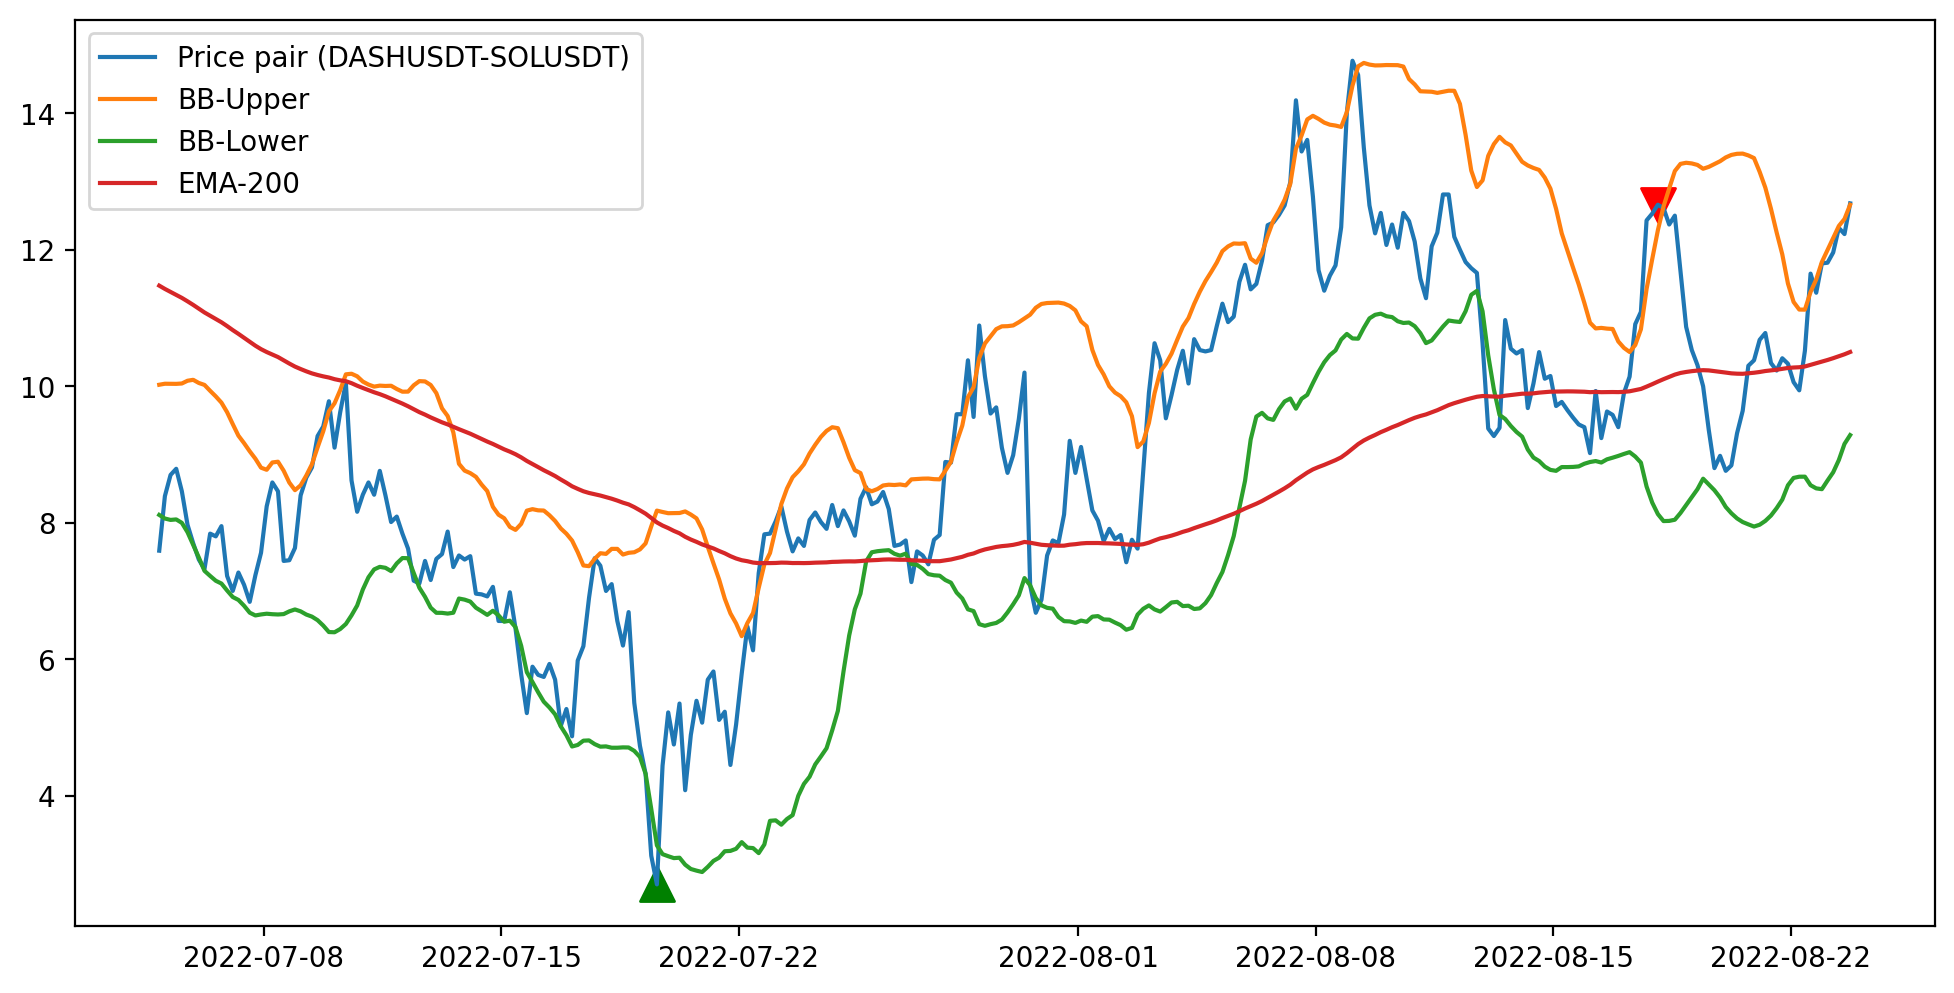

In [73]:
figure(figsize=(12,6), dpi=200)
df= df.tail(300)
buy_df = buy_df.tail(1)
sell_df = sell_df.tail(1)
plt.plot(df.close, label=f'Price pair ({coin1}-{coin2})')
plt.plot(df.upper, label=f'BB-Upper')
plt.plot(df.lower, label=f'BB-Lower')
plt.plot(df.ema_200, label=f'EMA-200')
plt.scatter(buy_df.index, buy_df.close.to_numpy(), marker ='^', s=150, c='g')
plt.scatter(sell_df.index, sell_df.close.to_numpy(), marker ='v', s=150, c='r')
plt.legend()

### Commit

In [ ]:
# Execute this to save new versions of the notebook
jovian.commit(project="ranton-mean-reversion-study-1")

<IPython.core.display.Javascript object>